# Bayesian Network Model - Comprehensive Evaluation Metrics

This notebook loads the saved Bayesian Network model and evaluates it with comprehensive quantitative metrics.

## 🔍 Evaluation Approach:
This notebook loads the actual **pgmpy Bayesian Network** from the saved pickle file and uses the inference engine to make predictions on the test set, then calculates all evaluation metrics.

## 📊 Metrics Covered:
- **Accuracy** (Testing)
- **Precision, Recall, F1-Score** (Macro & Weighted averages)
- **Confusion Matrix** with statistical analysis
- **Classification Report** (Per-Disease Performance)
- **Cohen's Kappa** score
- **Error Analysis** (misclassifications and confused pairs)
- **Confidence Score Analysis**
- **Visualizations** (charts and heatmaps)

## 📁 Output Files Generated:
1. `bayesian_confusion_matrix.png` - Confusion matrix heatmap
2. `bayesian_metrics_visualization.png` - Performance charts
3. `bayesian_evaluation_summary.csv` - Metrics summary table
4. `bayesian_per_disease_performance.csv` - Per-disease breakdown
5. `bayesian_metrics_detailed.txt` - Complete text report

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score
)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load the Saved Bayesian Network Model

In [2]:
# Load the saved Bayesian Network model
model_path = '../models/disease_bayesian_network.pkl'

try:
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    print(f"✓ Model loaded successfully from: {model_path}")
    print(f"\nModel Type: {type(model_data).__name__}")
    print("\n📦 Model dictionary contains:")
    for key in model_data.keys():
        print(f"  - {key}: {type(model_data[key]).__name__}")
    
    # Extract components
    bayesian_model = model_data['model']
    inference_engine = model_data['inference']
    symptom_cols = model_data['symptom_cols']
    diseases = model_data['diseases']
    
    print(f"\n✓ Bayesian Network extracted:")
    print(f"  - Model type: {type(bayesian_model).__name__}")
    print(f"  - Inference type: {type(inference_engine).__name__}")
    print(f"  - Symptoms: {len(symptom_cols)}")
    print(f"  - Diseases: {len(diseases)}")
    
    if 'accuracy' in model_data:
        print(f"  - Stored accuracy: {model_data['accuracy']*100:.2f}%")
        
except FileNotFoundError:
    print("❌ Model file not found. Please run 02_bayesian_network_binary.ipynb first to train the model.")
    raise

✓ Model loaded successfully from: ../models/disease_bayesian_network.pkl

Model Type: dict

📦 Model dictionary contains:
  - model: DiscreteBayesianNetwork
  - inference: VariableElimination
  - symptom_cols: list
  - diseases: list
  - accuracy: float
  - avg_confidence: float64

✓ Bayesian Network extracted:
  - Model type: DiscreteBayesianNetwork
  - Inference type: VariableElimination
  - Symptoms: 131
  - Diseases: 41
  - Stored accuracy: 94.51%


## 3. Load Test Data

In [3]:
# Load test dataset
test_df = pd.read_csv('../data/Testing_binary.csv')

print("Dataset Information:")
print("=" * 60)
print(f"Testing samples:  {test_df.shape[0]:,}")
print(f"Total features:   {test_df.shape[1] - 1} symptoms")
print(f"Disease classes:  {test_df['prognosis'].nunique()}")
print("\nClass Distribution (Testing):")
print(test_df['prognosis'].value_counts().head(10))

Dataset Information:
Testing samples:  492
Total features:   131 symptoms
Disease classes:  41

Class Distribution (Testing):
prognosis
Alcoholic hepatitis             12
Pneumonia                       12
Paralysis (brain hemorrhage)    12
Hepatitis B                     12
Gastroenteritis                 12
Hyperthyroidism                 12
Tuberculosis                    12
Cervical spondylosis            12
Peptic ulcer diseae             12
Psoriasis                       12
Name: count, dtype: int64


## 4. Generate Predictions Using Bayesian Network

In [4]:
# Make predictions on test set using the Bayesian Network inference engine
y_true = []
y_pred = []
confidence_scores = []

print("Generating predictions using Bayesian Network inference...")
print("=" * 70)

for idx, row in test_df.iterrows():
    # Get actual disease
    actual_disease = row['prognosis']
    
    # Get symptoms (only those present)
    symptoms = {col: int(row[col]) for col in symptom_cols if row[col] == 1}
    
    # Predict using Bayesian Network
    if symptoms:  # Only predict if there are symptoms
        try:
            # Query the Bayesian Network
            result = inference_engine.query(variables=['prognosis'], evidence=symptoms)
            
            # Extract probabilities
            probs = result.values
            disease_names = result.state_names['prognosis']
            
            # Get top prediction
            max_idx = np.argmax(probs)
            predicted_disease = disease_names[max_idx]
            confidence = probs[max_idx]
        except Exception as e:
            predicted_disease = "Unknown"
            confidence = 0.0
    else:
        predicted_disease = "Unknown"
        confidence = 0.0
    
    y_true.append(actual_disease)
    y_pred.append(predicted_disease)
    confidence_scores.append(confidence)
    
    if idx < 10:  # Show first 10 samples
        print(f"Sample {idx+1:3d}: {actual_disease:30s} → {predicted_disease:30s} ({confidence*100:6.2f}%)")

print(f"\n✓ Predictions generated for {len(y_true)} samples")
print(f"  Average confidence: {np.mean(confidence_scores)*100:.2f}%")

Generating predictions using Bayesian Network inference...
Sample   1: Alcoholic hepatitis            → Alcoholic hepatitis            (100.00%)
Sample   2: Pneumonia                      → Pneumonia                      (100.00%)
Sample   3: Paralysis (brain hemorrhage)   → Paralysis (brain hemorrhage)   (100.00%)
Sample   4: Hepatitis B                    → Hepatitis B                    (100.00%)
Sample   5: Gastroenteritis                → Gastroenteritis                (100.00%)
Sample   6: Hyperthyroidism                → Hyperthyroidism                (100.00%)
Sample   7: Tuberculosis                   → Tuberculosis                   (100.00%)
Sample   8: Cervical spondylosis           → Cervical spondylosis           (100.00%)
Sample   9: Peptic ulcer diseae            → Peptic ulcer diseae            (100.00%)
Sample  10: Psoriasis                      → Psoriasis                      (100.00%)

✓ Predictions generated for 492 samples
  Average confidence: 97.36%


## 5. Calculate Accuracy Scores

In [5]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
avg_confidence = np.mean(confidence_scores)

print("=" * 70)
print("ACCURACY SCORES")
print("=" * 70)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Average Confidence: {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")

# Interpretation
print("\n" + "=" * 70)
print("INTERPRETATION")
print("=" * 70)
if accuracy >= 0.90:
    print("✓ Excellent performance (≥ 90%)")
elif accuracy >= 0.80:
    print("✓ Good performance (80-90%)")
elif accuracy >= 0.70:
    print("⚠ Moderate performance (70-80%)")
else:
    print("❌ Poor performance (< 70%)")

# Store results for later use
results = {
    'accuracy': accuracy,
    'avg_confidence': avg_confidence
}

ACCURACY SCORES

Test Accuracy: 0.9451 (94.51%)
Average Confidence: 0.9736 (97.36%)

INTERPRETATION
✓ Excellent performance (≥ 90%)


## 6. Calculate Precision, Recall, and F1-Score

In [6]:
# Calculate metrics with different averaging methods
print("=" * 70)
print("PRECISION, RECALL, F1-SCORE")
print("=" * 70)

# Macro average (treats all classes equally)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("\n📊 MACRO AVERAGE (Equal weight to all diseases)")
print("-" * 70)
print(f"Precision: {precision_macro:.4f} ({precision_macro*100:.2f}%)")
print(f"Recall:    {recall_macro:.4f} ({recall_macro*100:.2f}%)")
print(f"F1-Score:  {f1_macro:.4f} ({f1_macro*100:.2f}%)")

# Weighted average (accounts for class imbalance)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n📊 WEIGHTED AVERAGE (Accounts for class imbalance)")
print("-" * 70)
print(f"Precision: {precision_weighted:.4f} ({precision_weighted*100:.2f}%)")
print(f"Recall:    {recall_weighted:.4f} ({recall_weighted*100:.2f}%)")
print(f"F1-Score:  {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")

# Store results
results.update({
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'f1_macro': f1_macro,
    'precision_weighted': precision_weighted,
    'recall_weighted': recall_weighted,
    'f1_weighted': f1_weighted
})

PRECISION, RECALL, F1-SCORE

📊 MACRO AVERAGE (Equal weight to all diseases)
----------------------------------------------------------------------
Precision: 0.9255 (92.55%)
Recall:    0.9451 (94.51%)
F1-Score:  0.9304 (93.04%)

📊 WEIGHTED AVERAGE (Accounts for class imbalance)
----------------------------------------------------------------------
Precision: 0.9255 (92.55%)
Recall:    0.9451 (94.51%)
F1-Score:  0.9304 (93.04%)


## 7. Additional Statistical Metrics

In [7]:
# Cohen's Kappa Score (measures inter-rater agreement)
kappa = cohen_kappa_score(y_true, y_pred)

print("=" * 70)
print("ADDITIONAL STATISTICAL METRICS")
print("=" * 70)
print(f"\nCohen's Kappa: {kappa:.4f}")

# Interpretation of Kappa
print("\nKappa Score Interpretation:")
if kappa > 0.80:
    print("✓ Almost perfect agreement (0.81-1.00)")
elif kappa > 0.60:
    print("✓ Substantial agreement (0.61-0.80)")
elif kappa > 0.40:
    print("⚠ Moderate agreement (0.41-0.60)")
else:
    print("❌ Fair to poor agreement (< 0.40)")

# Store results
results['kappa'] = kappa

ADDITIONAL STATISTICAL METRICS

Cohen's Kappa: 0.9437

Kappa Score Interpretation:
✓ Almost perfect agreement (0.81-1.00)


## 8. Confidence Score Analysis

CONFIDENCE SCORE ANALYSIS

Mean confidence:   0.9736 (97.36%)
Median confidence: 1.0000 (100.00%)
Std Dev:           0.1114
Min confidence:    0.2815 (28.15%)
Max confidence:    1.0000 (100.00%)

Confidence Distribution:
Very Low (0-50%)         4
Low (50-70%)            23
High (70-90%)            0
Very High (90-100%)    465
Name: count, dtype: int64


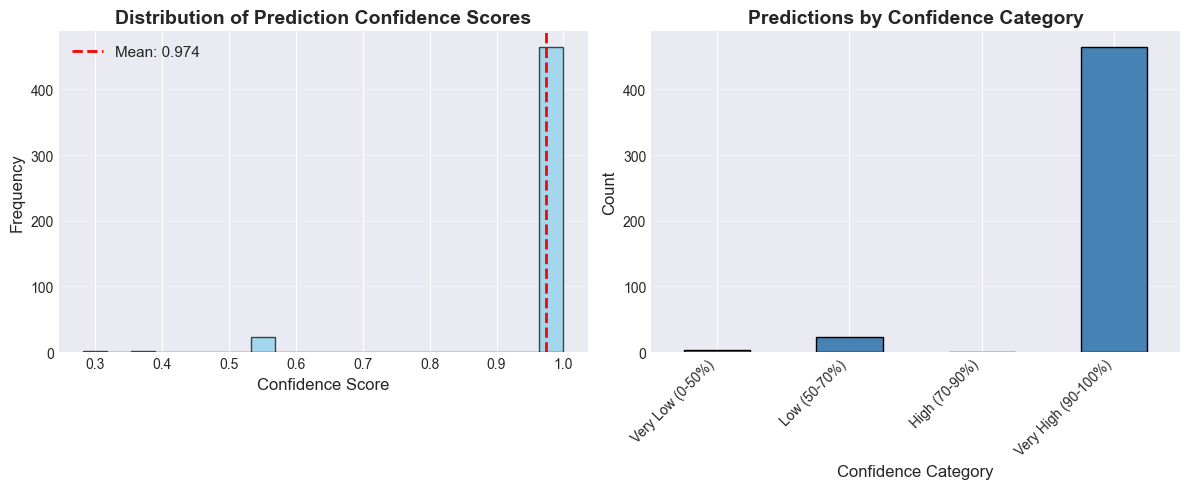

In [8]:
# Analyze confidence scores
print("=" * 70)
print("CONFIDENCE SCORE ANALYSIS")
print("=" * 70)

print(f"\nMean confidence:   {np.mean(confidence_scores):.4f} ({np.mean(confidence_scores)*100:.2f}%)")
print(f"Median confidence: {np.median(confidence_scores):.4f} ({np.median(confidence_scores)*100:.2f}%)")
print(f"Std Dev:           {np.std(confidence_scores):.4f}")
print(f"Min confidence:    {np.min(confidence_scores):.4f} ({np.min(confidence_scores)*100:.2f}%)")
print(f"Max confidence:    {np.max(confidence_scores):.4f} ({np.max(confidence_scores)*100:.2f}%)")

# Confidence distribution
confidence_bins = [0.0, 0.5, 0.7, 0.9, 1.0]
confidence_labels = ['Very Low (0-50%)', 'Low (50-70%)', 'High (70-90%)', 'Very High (90-100%)']
confidence_categories = pd.cut(confidence_scores, bins=confidence_bins, labels=confidence_labels)

print("\nConfidence Distribution:")
print(confidence_categories.value_counts().sort_index())

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
plt.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {avg_confidence:.3f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
confidence_categories.value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Confidence Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Predictions by Confidence Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Confusion Matrix Analysis

In [9]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("=" * 70)
print("CONFUSION MATRIX STATISTICS")
print("=" * 70)
print(f"\nMatrix Dimensions: {cm.shape[0]} x {cm.shape[1]}")
print(f"Total Predictions: {cm.sum():,}")
print(f"Correct Predictions: {np.diag(cm).sum():,}")
print(f"Incorrect Predictions: {cm.sum() - np.diag(cm).sum():,}")
print(f"\nAccuracy from CM: {np.diag(cm).sum() / cm.sum():.4f} ({np.diag(cm).sum() / cm.sum() * 100:.2f}%)")

# Per-class correct predictions
correct_per_class = np.diag(cm)
total_per_class = cm.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

print(f"\nMean per-disease accuracy: {accuracy_per_class.mean():.4f}")
print(f"Std per-disease accuracy: {accuracy_per_class.std():.4f}")
print(f"Min per-disease accuracy: {accuracy_per_class.min():.4f}")
print(f"Max per-disease accuracy: {accuracy_per_class.max():.4f}")

CONFUSION MATRIX STATISTICS

Matrix Dimensions: 41 x 41
Total Predictions: 492
Correct Predictions: 465
Incorrect Predictions: 27

Accuracy from CM: 0.9451 (94.51%)

Mean per-disease accuracy: 0.9451
Std per-disease accuracy: 0.2159
Min per-disease accuracy: 0.0000
Max per-disease accuracy: 1.0000


## 10. Visualize Confusion Matrix

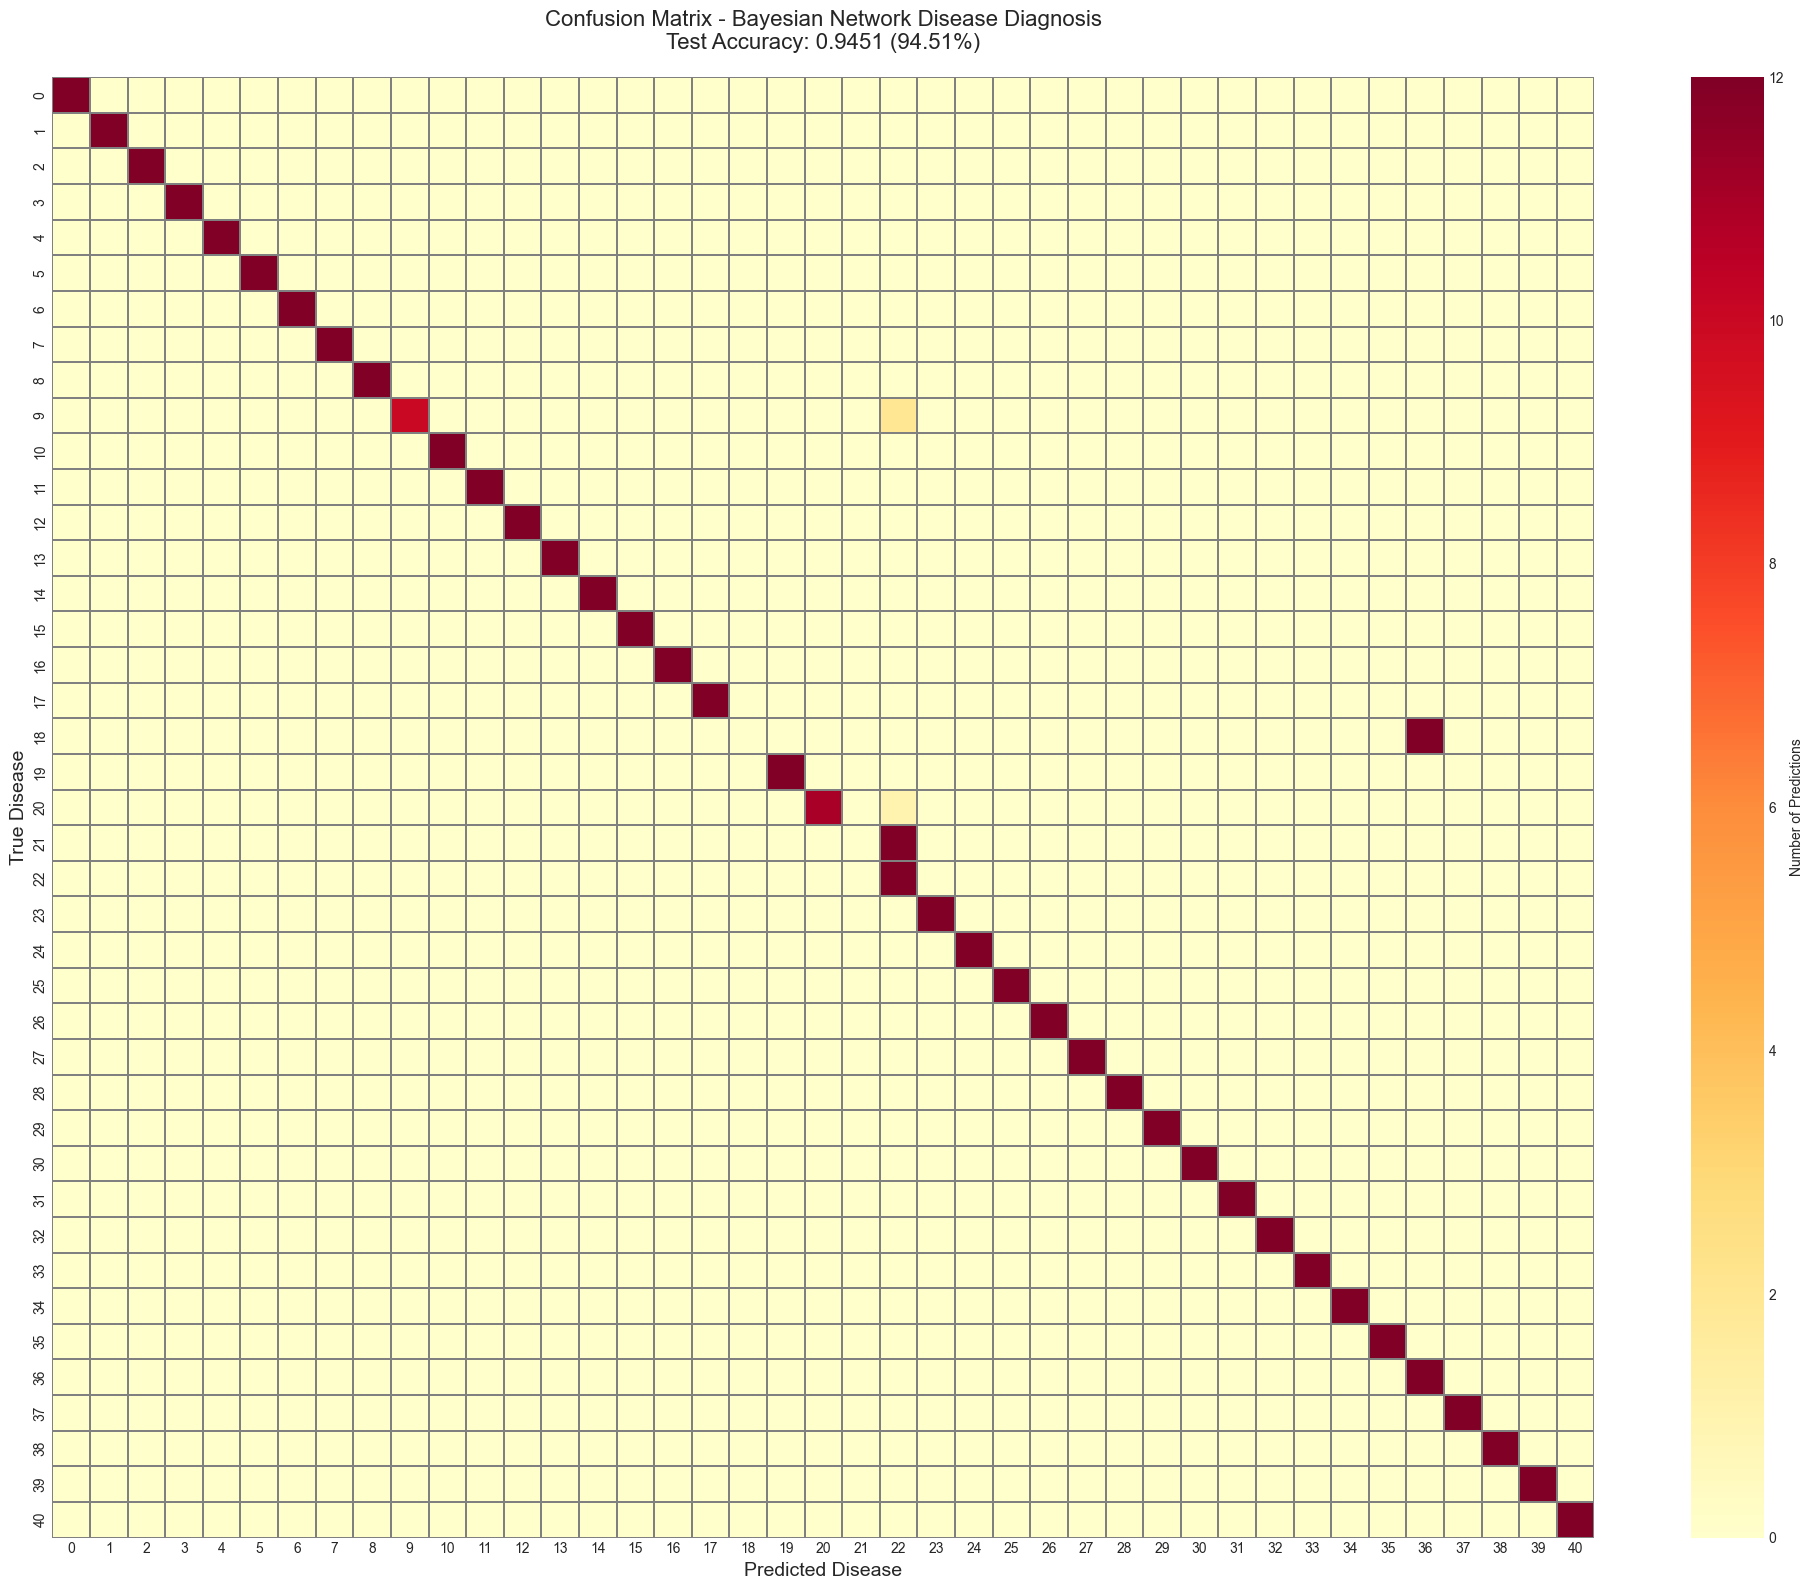

✓ Confusion matrix saved as 'bayesian_confusion_matrix.png'


In [10]:
# Create confusion matrix heatmap
plt.figure(figsize=(20, 16))

sns.heatmap(cm, 
            annot=False, 
            fmt='d', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Number of Predictions'},
            linewidths=0.1,
            linecolor='gray')

plt.title(f'Confusion Matrix - Bayesian Network Disease Diagnosis\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)', 
          fontsize=16, pad=20)
plt.ylabel('True Disease', fontsize=14)
plt.xlabel('Predicted Disease', fontsize=14)
plt.tight_layout()
plt.savefig('bayesian_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'bayesian_confusion_matrix.png'")

## 11. Detailed Classification Report

In [11]:
# Generate classification report
print("=" * 70)
print("DETAILED CLASSIFICATION REPORT (Testing Set)")
print("=" * 70)
print("\n")
print(classification_report(y_true, y_pred, zero_division=0))

# Get report as dictionary for further analysis
report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

DETAILED CLASSIFICATION REPORT (Testing Set)


                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        12
                                   AIDS       1.00      1.00      1.00        12
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        12
                                Allergy       1.00      1.00      1.00        12
                              Arthritis       1.00      1.00      1.00        12
                       Bronchial Asthma       1.00      1.00      1.00        12
                   Cervical spondylosis       1.00      1.00      1.00        12
                            Chicken pox       1.00      1.00      1.00        12
                    Chronic cholestasis       1.00      0.83      0.91        12
                            Common Cold       1.00      1.00 

## 12. Per-Disease Performance Analysis

In [12]:
# Extract per-disease metrics
disease_metrics = []

for disease in sorted(set(y_true)):
    if disease in report_dict and isinstance(report_dict[disease], dict):
        disease_metrics.append({
            'Disease': disease,
            'Precision': report_dict[disease]['precision'],
            'Recall': report_dict[disease]['recall'],
            'F1-Score': report_dict[disease]['f1-score'],
            'Support': int(report_dict[disease]['support'])
        })

disease_df = pd.DataFrame(disease_metrics)
disease_df = disease_df.sort_values('F1-Score', ascending=False)

print("=" * 90)
print("TOP 10 BEST PERFORMING DISEASES")
print("=" * 90)
print(f"\n{'Disease':<40} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Samples'}")
print("-" * 90)
for _, row in disease_df.head(10).iterrows():
    print(f"{row['Disease']:<40} {row['Precision']:>8.4f}     {row['Recall']:>8.4f}     {row['F1-Score']:>8.4f}     {row['Support']:>4}")

print("\n" + "=" * 90)
print("TOP 10 WORST PERFORMING DISEASES")
print("=" * 90)
print(f"\n{'Disease':<40} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Samples'}")
print("-" * 90)
for _, row in disease_df.tail(10).iterrows():
    print(f"{row['Disease']:<40} {row['Precision']:>8.4f}     {row['Recall']:>8.4f}     {row['F1-Score']:>8.4f}     {row['Support']:>4}")

TOP 10 BEST PERFORMING DISEASES

Disease                                  Precision    Recall       F1-Score     Samples
------------------------------------------------------------------------------------------
(vertigo) Paroymsal  Positional Vertigo    1.0000       1.0000       1.0000       12
AIDS                                       1.0000       1.0000       1.0000       12
Acne                                       1.0000       1.0000       1.0000       12
Alcoholic hepatitis                        1.0000       1.0000       1.0000       12
Allergy                                    1.0000       1.0000       1.0000       12
Arthritis                                  1.0000       1.0000       1.0000       12
Bronchial Asthma                           1.0000       1.0000       1.0000       12
Cervical spondylosis                       1.0000       1.0000       1.0000       12
Chicken pox                                1.0000       1.0000       1.0000       12
Common Cold            

## 13. Visualize Performance Metrics

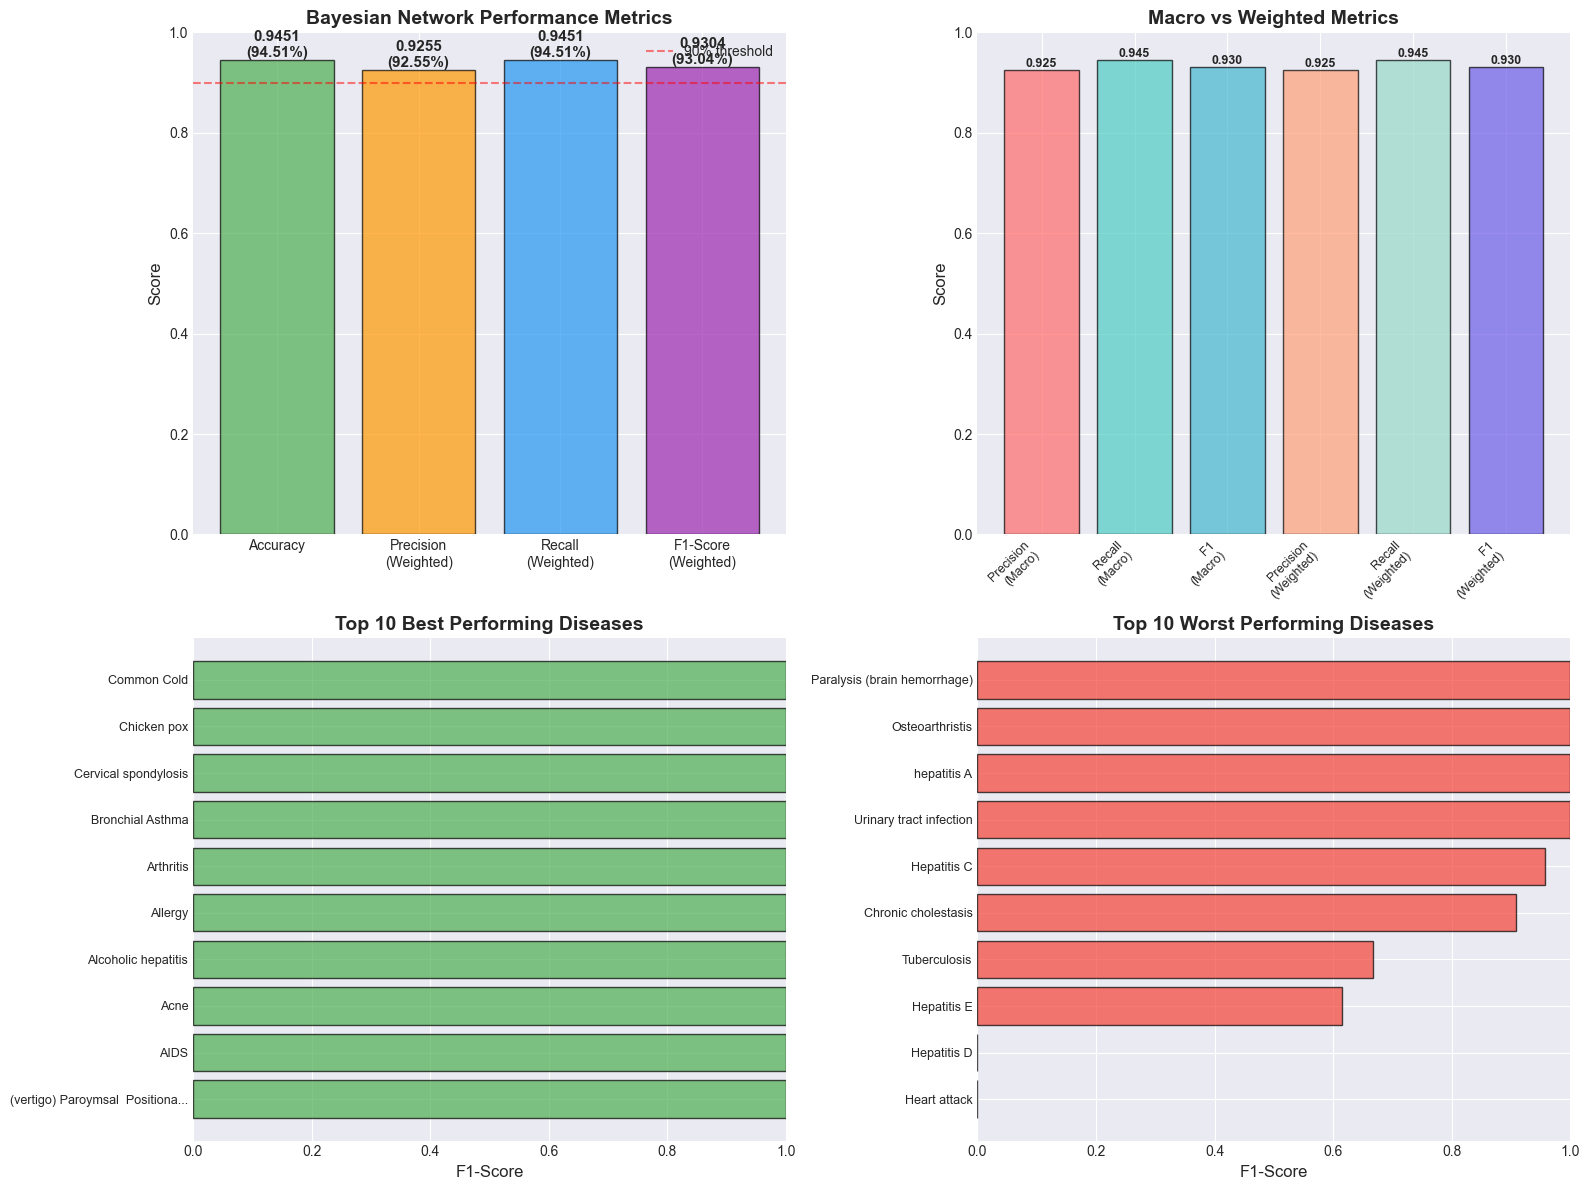

✓ Performance metrics visualization saved as 'bayesian_metrics_visualization.png'


In [13]:
# Create comprehensive metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Metrics Comparison
ax1 = axes[0, 0]
metrics_names = ['Accuracy', 'Precision\n(Weighted)', 'Recall\n(Weighted)', 'F1-Score\n(Weighted)']
metrics_values = [accuracy, precision_weighted, recall_weighted, f1_weighted]
colors = ['#4CAF50', '#FF9800', '#2196F3', '#9C27B0']
bars = ax1.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Bayesian Network Performance Metrics', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='90% threshold')
ax1.legend()
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}\n({val*100:.2f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Macro vs Weighted Metrics
ax2 = axes[0, 1]
metric_types = ['Precision\n(Macro)', 'Recall\n(Macro)', 'F1\n(Macro)', 
                'Precision\n(Weighted)', 'Recall\n(Weighted)', 'F1\n(Weighted)']
metric_vals = [precision_macro, recall_macro, f1_macro, 
               precision_weighted, recall_weighted, f1_weighted]
colors2 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#6C5CE7']
bars2 = ax2.bar(range(len(metric_types)), metric_vals, color=colors2, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(metric_types)))
ax2.set_xticklabels(metric_types, fontsize=9, rotation=45, ha='right')
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Macro vs Weighted Metrics', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
for bar, val in zip(bars2, metric_vals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Top 10 Diseases by F1-Score
ax3 = axes[1, 0]
top_10 = disease_df.head(10).sort_values('F1-Score')
ax3.barh(range(len(top_10)), top_10['F1-Score'], color='#4CAF50', alpha=0.7, edgecolor='black')
ax3.set_yticks(range(len(top_10)))
ax3.set_yticklabels([d[:30] + '...' if len(d) > 30 else d for d in top_10['Disease']], fontsize=9)
ax3.set_xlabel('F1-Score', fontsize=12)
ax3.set_title('Top 10 Best Performing Diseases', fontsize=14, fontweight='bold')
ax3.set_xlim([0, 1])

# 4. Bottom 10 Diseases by F1-Score
ax4 = axes[1, 1]
bottom_10 = disease_df.tail(10).sort_values('F1-Score')
ax4.barh(range(len(bottom_10)), bottom_10['F1-Score'], color='#F44336', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(bottom_10)))
ax4.set_yticklabels([d[:30] + '...' if len(d) > 30 else d for d in bottom_10['Disease']], fontsize=9)
ax4.set_xlabel('F1-Score', fontsize=12)
ax4.set_title('Top 10 Worst Performing Diseases', fontsize=14, fontweight='bold')
ax4.set_xlim([0, 1])

plt.tight_layout()
plt.savefig('bayesian_metrics_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Performance metrics visualization saved as 'bayesian_metrics_visualization.png'")

## 14. Error Analysis

In [14]:
# Identify misclassifications
misclassified_mask = [yt != yp for yt, yp in zip(y_true, y_pred)]
misclassified_indices = [i for i, m in enumerate(misclassified_mask) if m]

print("=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)
print(f"\nTotal Test Samples: {len(y_true)}")
print(f"Correctly Classified: {sum([not m for m in misclassified_mask])} ({sum([not m for m in misclassified_mask])/len(y_true)*100:.2f}%)")
print(f"Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_true)*100:.2f}%)")

if len(misclassified_indices) > 0:
    print("\n" + "=" * 80)
    print("SAMPLE MISCLASSIFICATIONS (First 10)")
    print("=" * 80)
    print(f"\n{'#':<5} {'True Disease':<35} {'Predicted Disease':<35} {'Confidence'}")
    print("-" * 80)
    
    for i, idx in enumerate(misclassified_indices[:10], 1):
        true_disease = y_true[idx]
        pred_disease = y_pred[idx]
        conf = confidence_scores[idx]
        print(f"{i:<5} {true_disease:<35} {pred_disease:<35} {conf*100:6.2f}%")
    
    # Most confused disease pairs
    confusion_pairs = {}
    for idx in misclassified_indices:
        true_disease = y_true[idx]
        pred_disease = y_pred[idx]
        pair = (true_disease, pred_disease)
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "=" * 80)
    print("MOST CONFUSED DISEASE PAIRS (Top 10)")
    print("=" * 80)
    print(f"\n{'True Disease':<35} {'Predicted As':<35} {'Count'}")
    print("-" * 80)
    for (true_d, pred_d), count in sorted_pairs[:10]:
        print(f"{true_d:<35} {pred_d:<35} {count}")
else:
    print("\n✓ Perfect classification! No misclassifications found.")

ERROR ANALYSIS

Total Test Samples: 492
Correctly Classified: 465 (94.51%)
Misclassified: 27 (5.49%)

SAMPLE MISCLASSIFICATIONS (First 10)

#     True Disease                        Predicted Disease                   Confidence
--------------------------------------------------------------------------------
1     Heart attack                        Tuberculosis                         56.17%
2     Heart attack                        Tuberculosis                         56.17%
3     Heart attack                        Tuberculosis                         56.17%
4     Hepatitis D                         Hepatitis E                          54.76%
5     Hepatitis D                         Hepatitis E                          54.75%
6     Hepatitis D                         Hepatitis E                          54.28%
7     Chronic cholestasis                 Hepatitis E                          28.15%
8     Hepatitis D                         Hepatitis E                          54.51%
9 

## 15. Summary of All Metrics

In [15]:
# Create comprehensive summary
print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("=" * 80)

summary_df = pd.DataFrame([
    {'Metric': 'Testing Accuracy', 'Score': f"{accuracy:.4f} ({accuracy*100:.2f}%)"},
    {'Metric': 'Average Confidence', 'Score': f"{avg_confidence:.4f} ({avg_confidence*100:.2f}%)"},
    {'Metric': '', 'Score': ''},
    {'Metric': 'Test Precision (Macro)', 'Score': f"{precision_macro:.4f} ({precision_macro*100:.2f}%)"},
    {'Metric': 'Test Recall (Macro)', 'Score': f"{recall_macro:.4f} ({recall_macro*100:.2f}%)"},
    {'Metric': 'Test F1-Score (Macro)', 'Score': f"{f1_macro:.4f} ({f1_macro*100:.2f}%)"},
    {'Metric': '', 'Score': ''},
    {'Metric': 'Test Precision (Weighted)', 'Score': f"{precision_weighted:.4f} ({precision_weighted*100:.2f}%)"},
    {'Metric': 'Test Recall (Weighted)', 'Score': f"{recall_weighted:.4f} ({recall_weighted*100:.2f}%)"},
    {'Metric': 'Test F1-Score (Weighted)', 'Score': f"{f1_weighted:.4f} ({f1_weighted*100:.2f}%)"},
    {'Metric': '', 'Score': ''},
    {'Metric': "Cohen's Kappa (Test)", 'Score': f"{kappa:.4f}"},
    {'Metric': '', 'Score': ''},
    {'Metric': 'Total Test Samples', 'Score': f"{len(y_true):,}"},
    {'Metric': 'Correct Predictions', 'Score': f"{sum([not m for m in misclassified_mask]):,}"},
    {'Metric': 'Misclassifications', 'Score': f"{len(misclassified_indices):,}"},
])

print("\n" + summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv('bayesian_evaluation_summary.csv', index=False)
print("\n✓ Summary saved to 'bayesian_evaluation_summary.csv'")


COMPREHENSIVE EVALUATION SUMMARY

                   Metric           Score
         Testing Accuracy 0.9451 (94.51%)
       Average Confidence 0.9736 (97.36%)
                                         
   Test Precision (Macro) 0.9255 (92.55%)
      Test Recall (Macro) 0.9451 (94.51%)
    Test F1-Score (Macro) 0.9304 (93.04%)
                                         
Test Precision (Weighted) 0.9255 (92.55%)
   Test Recall (Weighted) 0.9451 (94.51%)
 Test F1-Score (Weighted) 0.9304 (93.04%)
                                         
     Cohen's Kappa (Test)          0.9437
                                         
       Total Test Samples             492
      Correct Predictions             465
       Misclassifications              27

✓ Summary saved to 'bayesian_evaluation_summary.csv'


## 16. Export Results

In [ ]:
# Save detailed disease performance to CSV
disease_df.to_csv('bayesian_per_disease_performance.csv', index=False)
print("✓ Per-disease performance saved to 'bayesian_per_disease_performance.csv'")

# Save all results to a text file
with open('bayesian_metrics_detailed.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("BAYESIAN NETWORK MODEL - DETAILED EVALUATION METRICS\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("ACCURACY SCORES\n")
    f.write("-" * 80 + "\n")
    f.write(f"Testing Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"Average Confidence: {avg_confidence:.4f} ({avg_confidence*100:.2f}%)\n\n")
    
    f.write("TESTING SET METRICS (WEIGHTED AVERAGE)\n")
    f.write("-" * 80 + "\n")
    f.write(f"Precision:  {precision_weighted:.4f} ({precision_weighted*100:.2f}%)\n")
    f.write(f"Recall:     {recall_weighted:.4f} ({recall_weighted*100:.2f}%)\n")
    f.write(f"F1-Score:   {f1_weighted:.4f} ({f1_weighted*100:.2f}%)\n\n")
    
    f.write("TESTING SET METRICS (MACRO AVERAGE)\n")
    f.write("-" * 80 + "\n")
    f.write(f"Precision:  {precision_macro:.4f} ({precision_macro*100:.2f}%)\n")
    f.write(f"Recall:     {recall_macro:.4f} ({recall_macro*100:.2f}%)\n")
    f.write(f"F1-Score:   {f1_macro:.4f} ({f1_macro*100:.2f}%)\n\n")
    
    f.write("ADDITIONAL METRICS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Cohen's Kappa: {kappa:.4f}\n\n")
    
    f.write("MODEL INFORMATION\n")
    f.write("-" * 80 + "\n")
    f.write(f"Model Type: Bayesian Network (pgmpy)\n")
    f.write(f"Inference: Variable Elimination\n")
    f.write(f"Symptoms: {len(symptom_cols)}\n")
    f.write(f"Diseases: {len(diseases)}\n")

print("✓ Detailed metrics saved to 'bayesian_metrics_detailed.txt'")

print("\n" + "=" * 80)
print("✓ EVALUATION COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nGenerated Files:")
print("  1. bayesian_confusion_matrix.png - Full confusion matrix heatmap")
print("  2. bayesian_metrics_visualization.png - Performance visualization")
print("  3. bayesian_evaluation_summary.csv - Summary of all metrics")
print("  4. bayesian_per_disease_performance.csv - Per-disease performance metrics")
print("  5. bayesian_metrics_detailed.txt - Detailed text report")

## 17. Final Summary

In [ ]:
print("=" * 80)
print("BAYESIAN NETWORK EVALUATION - FINAL SUMMARY")
print("=" * 80)
print(f"\n🎯 Model Performance:")
print(f"  • Accuracy: {accuracy*100:.2f}%")
print(f"  • F1-Score (Weighted): {f1_weighted*100:.2f}%")
print(f"  • Precision (Weighted): {precision_weighted*100:.2f}%")
print(f"  • Recall (Weighted): {recall_weighted*100:.2f}%")
print(f"  • Cohen's Kappa: {kappa:.4f}")

print(f"\n📊 Dataset:")
print(f"  • Test Samples: {len(y_true):,}")
print(f"  • Diseases: {len(set(y_true))}")
print(f"  • Symptoms: {len(symptom_cols)}")

print(f"\n🔍 Confidence:")
print(f"  • Average: {avg_confidence*100:.2f}%")
print(f"  • Range: {np.min(confidence_scores)*100:.2f}% - {np.max(confidence_scores)*100:.2f}%")

print(f"\n❌ Errors:")
print(f"  • Misclassifications: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_true)*100:.2f}%)")

print("\n✓ Evaluation complete! All metrics and visualizations have been saved.")
print("=" * 80)